# Zillow Time Series

In [1]:
#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium


#Data Preprocesing

#Data Modeling  
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


#Data Evaluation 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Forecasting 
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly


# Ignore any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
df = pd.read_csv('Data/zillow_metro_areas.csv')
df.head(2)

RegionID  SizeRank     RegionName RegionType StateName  2000-01-31  \
0    102001         0  United States    Country       NaN    127569.0   
1    394913         1   New York, NY        Msa        NY    225438.0   

   2000-02-29  2000-03-31  2000-04-30  2000-05-31  ...  2020-12-31  \
0    127914.0    128277.0    129016.0    129762.0  ...    269165.0   
1    226785.0    227997.0    230383.0    232604.0  ...    514350.0   

   2021-01-31  2021-02-28  2021-03-31  2021-04-30  2021-05-31  2021-06-30  \
0    272132.0    275247.0    278593.0    282335.0    286913.0    292304.0   
1    519193.0    523962.0    528241.0    532983.0    538439.0    545638.0   

   2021-07-31  2021-08-31  2021-09-30  
0    298069.0    303296.0    308220.0  
1    553551.0    561136.0    567059.0  

[2 rows x 266 columns]

# Step 1: Load the Data/Filtering for Chosen City

In [3]:
df.head(2)

RegionID  SizeRank     RegionName RegionType StateName  2000-01-31  \
0    102001         0  United States    Country       NaN    127569.0   
1    394913         1   New York, NY        Msa        NY    225438.0   

   2000-02-29  2000-03-31  2000-04-30  2000-05-31  ...  2020-12-31  \
0    127914.0    128277.0    129016.0    129762.0  ...    269165.0   
1    226785.0    227997.0    230383.0    232604.0  ...    514350.0   

   2021-01-31  2021-02-28  2021-03-31  2021-04-30  2021-05-31  2021-06-30  \
0    272132.0    275247.0    278593.0    282335.0    286913.0    292304.0   
1    519193.0    523962.0    528241.0    532983.0    538439.0    545638.0   

   2021-07-31  2021-08-31  2021-09-30  
0    298069.0    303296.0    308220.0  
1    553551.0    561136.0    567059.0  

[2 rows x 266 columns]

### Choose a State to focus on

In [4]:
df['StateName'].value_counts().head(10)

TX    66
OH    45
NC    39
GA    37
IN    36
CA    34
PA    34
MI    33
FL    29
IL    27
Name: StateName, dtype: int64

## Focus on New York State


In [5]:
df = df[df['StateName']=='NY']
df.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2021-05-31    1
2021-06-30    0
2021-07-31    0
2021-08-31    0
2021-09-30    0
Length: 266, dtype: int64

In [6]:
# See Regions
df['RegionName'].value_counts()

Cortland, NY        1
Kingston, NY        1
Binghamton, NY      1
Ogdensburg, NY      1
Malone, NY          1
Glens Falls, NY     1
Seneca Falls, NY    1
Plattsburgh, NY     1
Olean, NY           1
Utica, NY           1
Syracuse, NY        1
Watertown, NY       1
Ithaca, NY          1
Hudson, NY          1
Auburn, NY          1
Gloversville, NY    1
Albany, NY          1
Batavia, NY         1
Oneonta, NY         1
Corning, NY         1
Jamestown, NY       1
Amsterdam, NY       1
Buffalo, NY         1
New York, NY        1
Rochester, NY       1
Elmira, NY          1
Name: RegionName, dtype: int64

# Step 2: Data Preprocessing

In [7]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

### Creating Statistical Columns

- Create ROI, Standard Deviation and Mean

In [8]:
#Calculate historical return on investment

#df['ROI']= ( (df['2021-09-30']/df['2000-01-31'])-1 ) *100 
#or
df['ROI']= (  (df['2021-09-30']-df['2000-01-31'])/df['2000-01-31'] ) *100 


#Calculate standard deviation of monthly values
df['std']=df.loc[:,'2000-01-31':'2021-09-30'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'2000-01-31':'2021-09-30'].mean(skipna=True, axis=1)


In [9]:
df[['std','mean','ROI']].head()

std           mean         ROI
1   72598.360721  409101.000000  151.536564
47  27085.263028  131671.557692  140.335008
51  17954.160376  131403.904215   92.857426
60  30773.612628  176286.505747  129.552385
79  18868.807739  122148.214559  113.232829

## Reshape from Wide to Long Format

In [10]:
#cleaning melted dataFrame column RegionName

df['RegionName'] = df['RegionName'].apply(lambda x: x[:-4] )
df.head(2)

RegionID  SizeRank RegionName RegionType StateName  2000-01-31  \
1     394913         1   New York        Msa        NY    225438.0   
47    394425        47    Buffalo        Msa        NY     93968.0   

    2000-02-29  2000-03-31  2000-04-30  2000-05-31  ...  2021-03-31  \
1     226785.0    227997.0    230383.0    232604.0  ...    528241.0   
47     94487.0     94871.0     95602.0     96126.0  ...    201195.0   

    2021-04-30  2021-05-31  2021-06-30  2021-07-31  2021-08-31  2021-09-30  \
1     532983.0    538439.0    545638.0    553551.0    561136.0    567059.0   
47    203599.0         NaN    214992.0    221501.0    224418.0    225838.0   

           ROI           std           mean  
1   151.536564  72598.360721  409101.000000  
47  140.335008  27085.263028  131671.557692  

[2 rows x 269 columns]

In [11]:
#we dont need
df.drop(['RegionID', 'SizeRank'], axis=1,inplace=True)


In [12]:
df.columns

Index(['RegionName', 'RegionType', 'StateName', '2000-01-31', '2000-02-29',
       '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31',
       ...
       '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
       '2021-08-31', '2021-09-30', 'ROI', 'std', 'mean'],
      dtype='object', length=267)

In [13]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','RegionType', 'StateName','ROI','std','mean'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [14]:
df_melted = melt_data(df)
df_melted

RegionName RegionType StateName         ROI           std  \
0         New York        Msa        NY  151.536564  72598.360721   
1          Buffalo        Msa        NY  140.335008  27085.263028   
2        Rochester        Msa        NY   92.857426  17954.160376   
3           Albany        Msa        NY  129.552385  30773.612628   
4         Syracuse        Msa        NY  113.232829  18868.807739   
...            ...        ...       ...         ...           ...   
6781  Gloversville        Msa        NY  177.816183  19424.100888   
6782        Malone        Msa        NY  146.809470  17181.668402   
6783     Amsterdam        Msa        NY  140.750400  17308.745203   
6784      Cortland        Msa        NY  149.174048  20959.362905   
6785  Seneca Falls        Msa        NY  119.783959  16770.215142   

               mean       time     value  
0     409101.000000 2000-01-31  225438.0  
1     131671.557692 2000-01-31   93968.0  
2     131403.904215 2000-01-31  100972.0  
3     176286.505747 2000-01-31  108218.0  
4     122148.214559 2000-01-31   83512.0  
...             ...        ...       ...  
6781   92593.141762 2021-09-30  147087.0  
6782   86748.107280 2021-09-30  125937.0  
6783   93860.659004 2021-09-30  133850.0  
6784  100346.831418 2021-09-30  145712.0  
6785   97401.065134 2021-09-30  140798.0  

[6785 rows x 8 columns]

### Sorting by hightest ROI

In [15]:
#From 2000
top_15_metro = df_melted.loc[df_melted.groupby("RegionName")["ROI"].\
              idxmax()].sort_values('ROI',
                                    ascending=False)[:15]
top_15_metro.reset_index(drop = 1)


RegionName RegionType StateName         ROI           std  \
0        Oneonta        Msa        NY  225.067117  31029.180385   
1         Hudson        Msa        NY  222.014939  47299.592446   
2      Watertown        Msa        NY  206.661853  31556.915271   
3       Kingston        Msa        NY  188.390130  42602.158350   
4    Glens Falls        Msa        NY  178.696213  33692.281393   
5   Gloversville        Msa        NY  177.816183  19424.100888   
6         Ithaca        Msa        NY  162.540068  42278.707190   
7       New York        Msa        NY  151.536564  72598.360721   
8       Cortland        Msa        NY  149.174048  20959.362905   
9         Malone        Msa        NY  146.809470  17181.668402   
10         Utica        Msa        NY  142.233291  19854.100220   
11        Auburn        Msa        NY  142.006688  20233.385194   
12     Amsterdam        Msa        NY  140.750400  17308.745203   
13       Buffalo        Msa        NY  140.335008  27085.263028   
14        Albany        Msa        NY  129.552385  30773.612628   

             mean       time     value  
0   113908.344828 2000-01-31   52148.0  
1   205821.812261 2000-01-31  107100.0  
2   114905.555556 2000-01-31   54009.0  
3   216531.574713 2000-01-31  121457.0  
4   151282.122605 2000-01-31   81455.0  
5    92593.141762 2000-01-31   52944.0  
6   175432.701149 2000-01-31   95462.0  
7   409101.000000 2000-01-31  225438.0  
8   100346.831418 2000-01-31   58478.0  
9    86748.107280 2000-01-31   51026.0  
10  109455.153257 2000-01-31   70873.0  
11  111451.045977 2000-01-31   65192.0  
12   93860.659004 2000-01-31   55597.0  
13  131671.557692 2000-01-31   93968.0  
14  176286.505747 2000-01-31  108218.0

# Unstack these top 10

- Go back to long shape to start modeling

......

- Or just check those 10 individually :) 

In [16]:
# #LOL no

# df_values = pd.DataFrame(top_10_metro[['RegionName','value']], 
#                          index = top_10_metro.index)

# df_values.reset_index(inplace=True)
# df_values

# df_values = df_values.pivot('time', 'RegionName', 'value')
# df_values

# Step 3: EDA and Visualization

In [17]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}


# #plt.rc('font', **font)
# matplotlib.rc('font', **font)

# # NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!
# #plt.gcf().autofmt_xdate()





In [18]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return df_test

### Those functions ¯\_(ツ)_/¯ 

what the best zipcodes have that the other ones dont


# Step 5: ARIMA Modeling

# Step 6: Interpreting Results

# Map Visualizations

In [19]:
# https://python-visualization.github.io/folium/quickstart.html

In [20]:
#pip install folium
#import folium

#[Latitude ,Longitude]
NY = folium.Map(location=[40.730610, -73.935242])

tooltip = "Click me!"
folium.Marker(
    [40.730610, -73.935242], popup="<i> NY Here</i>", tooltip=tooltip
).add_to(NY)


NY

# Facebook Prophet

In [21]:
def Facebook(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecasts plots
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    
    # From 2010
    city_melted = city_melted[city_melted['ds'] > '2009']
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    #print(prophet_ROI)
    #fig1 = prophet_model.plot(forecast)
    fig2 = prophet_model.plot_components(forecast)
    fig3 = plot_plotly(prophet_model, forecast)
    fig4 = plot_components_plotly(prophet_model, forecast)

    return fig3
    #return prophet_ROI
    

In [22]:
def Facebook_ROI(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecast ROI
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    #Indicate from what year 
    city_melted = city_melted[city_melted['ds'] > '2009']
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    
    return prophet_ROI
    
  
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

{'New York': Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2009, 1, 31, 0, 0),
                          datetime.datetime(2009, 2, 28, 0, 0),
                          datetime.datetime(2009, 3, 31, 0, 0),
                          datetime.datetime(2009, 4, 30, 0, 0),
                          datetime.datetime(2009, 5, 31, 0, 0),
                          datetime.datetime(2009, 6, 30, 0, 0),
                          datetime.datetime(2009, 7, 31, 0, 0),
                          datetime.datetime(2009, 8, 31, 0, 0),
                          datetime.datetime(2009, 9, 30, 0, 0),
                          datetime.datetime(2009, 10, 31, 0, 0),
                          datetime.datetime(2009, 11, 30, 0, 0),
                          datetime.datetime(2009, 12, 31, 0, 0),
                          datetime.datetime(2010, 1, 3

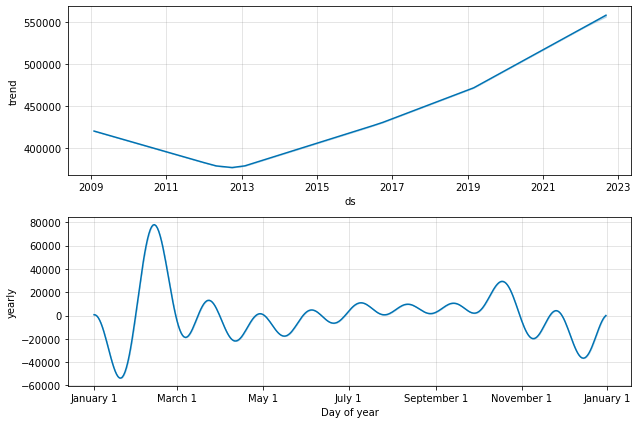

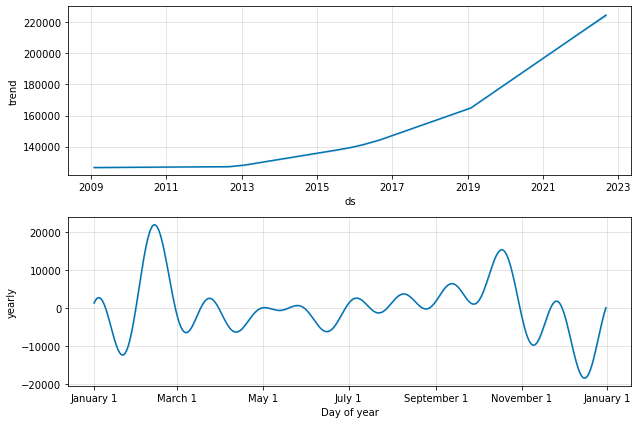

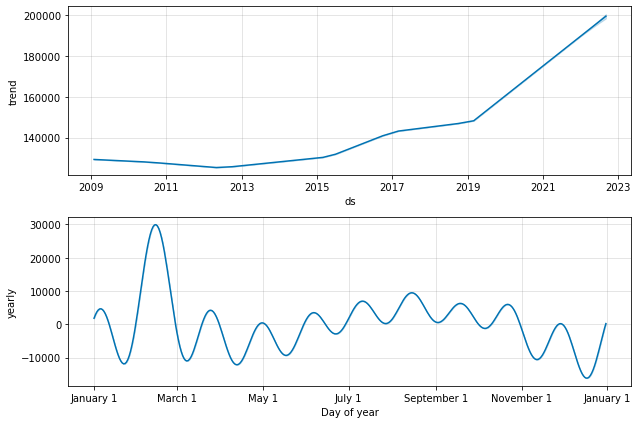

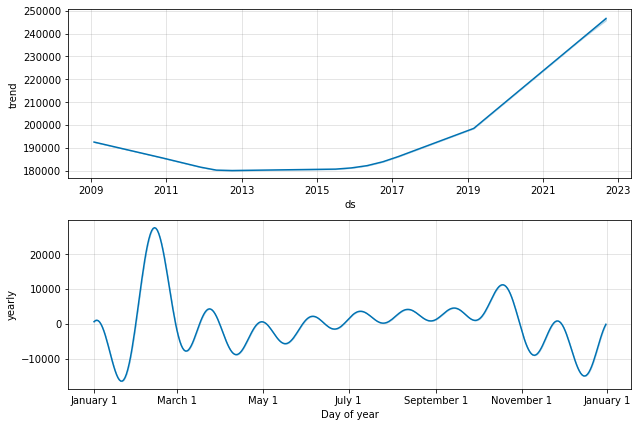

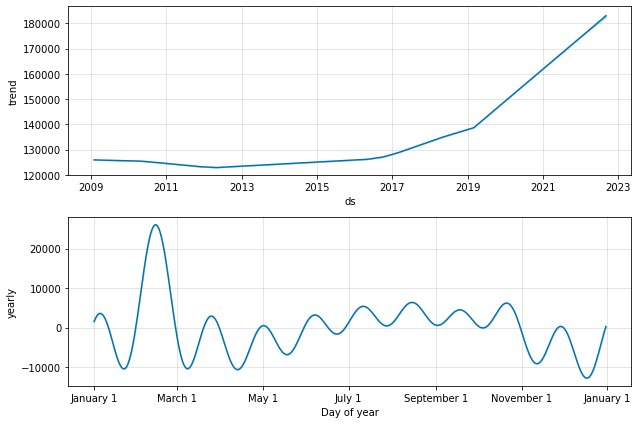

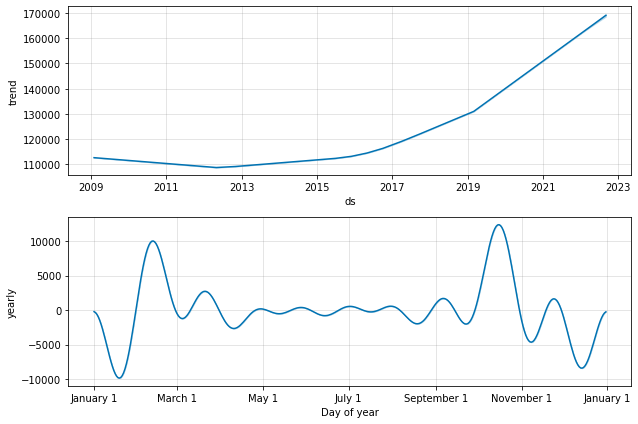

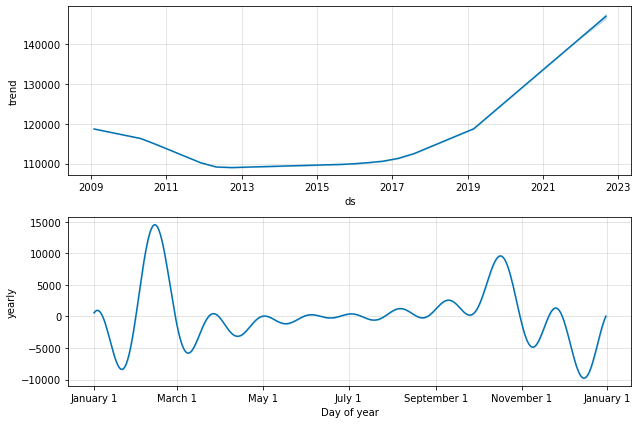

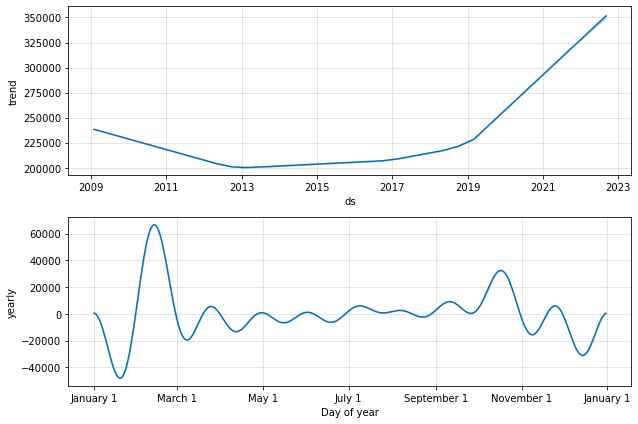

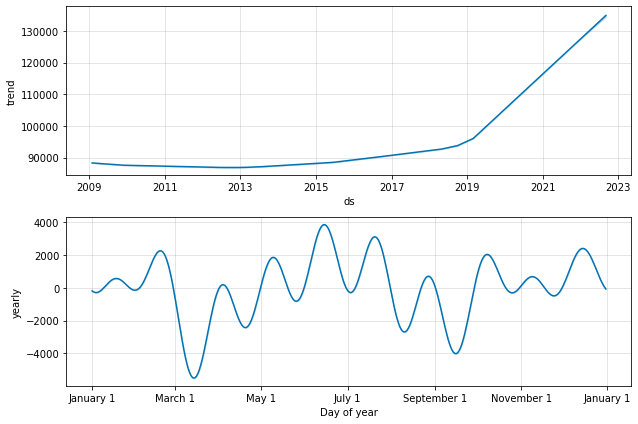

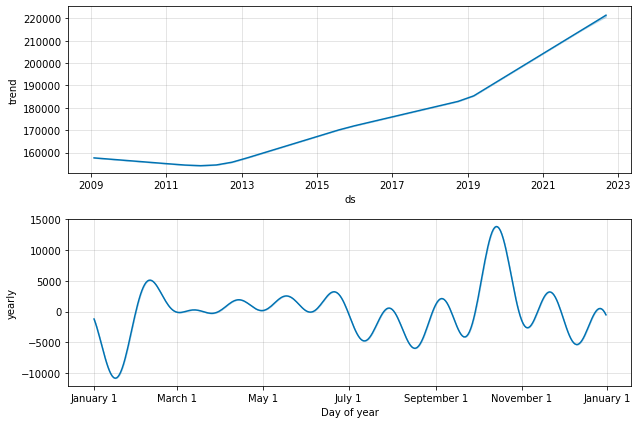

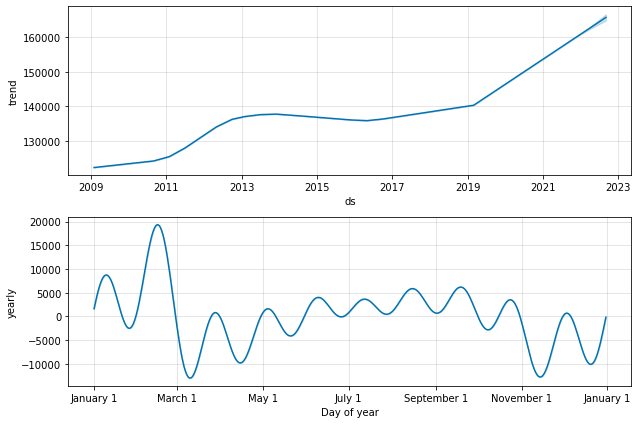

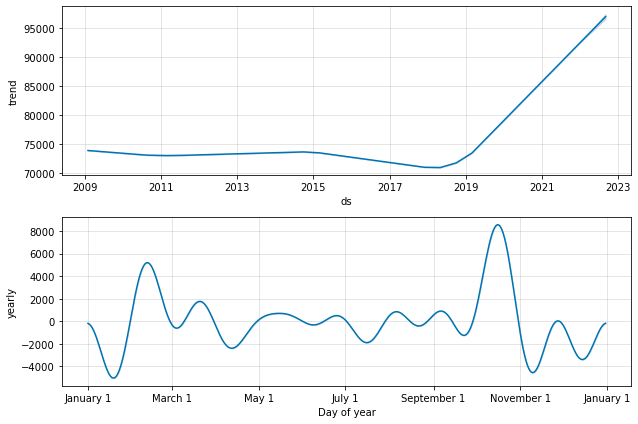

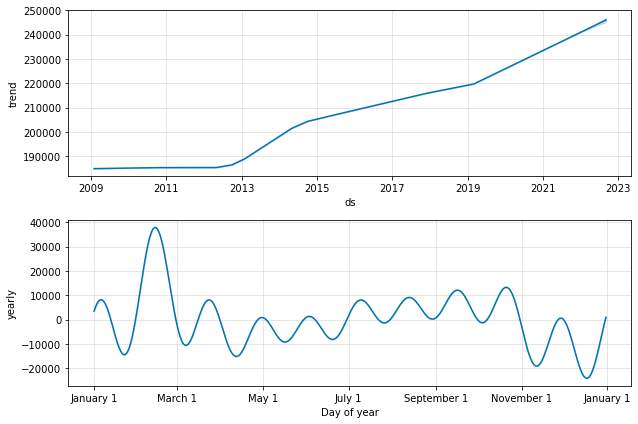

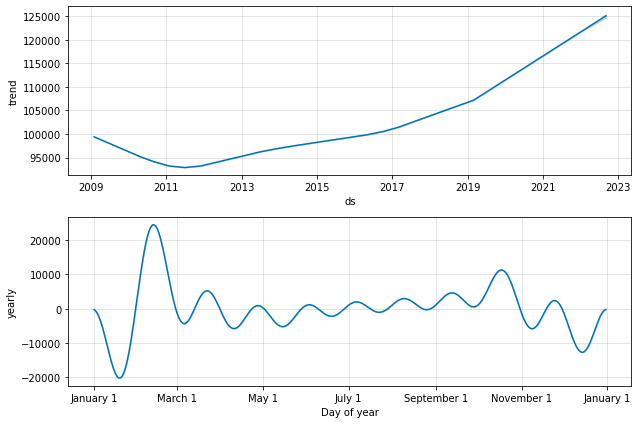

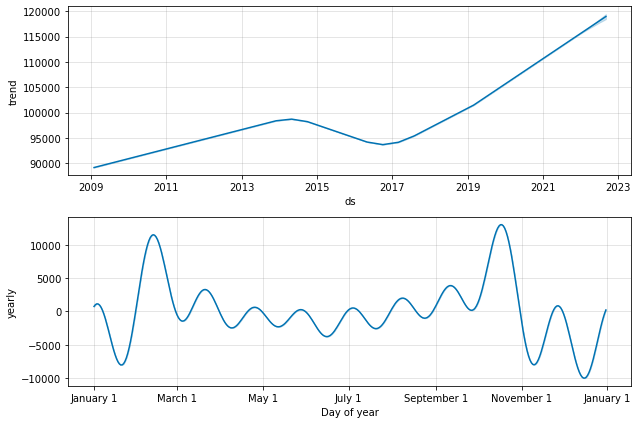

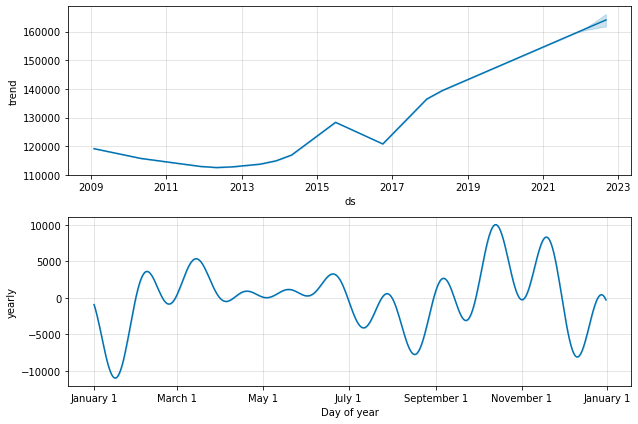

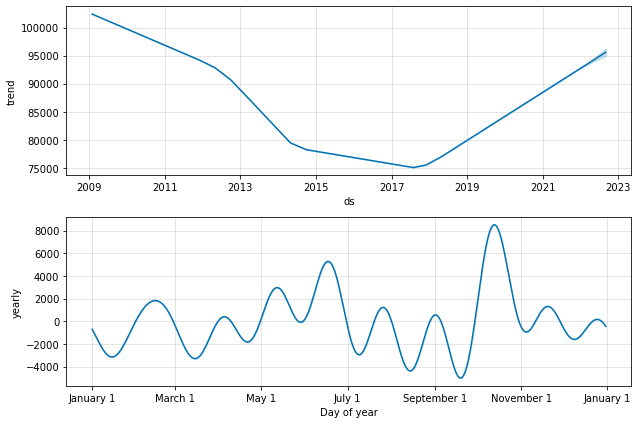

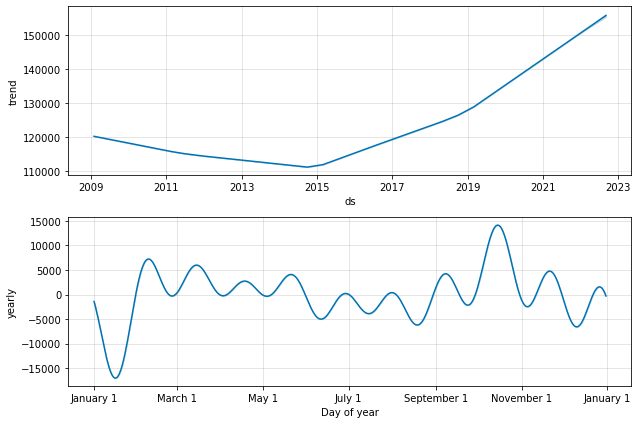

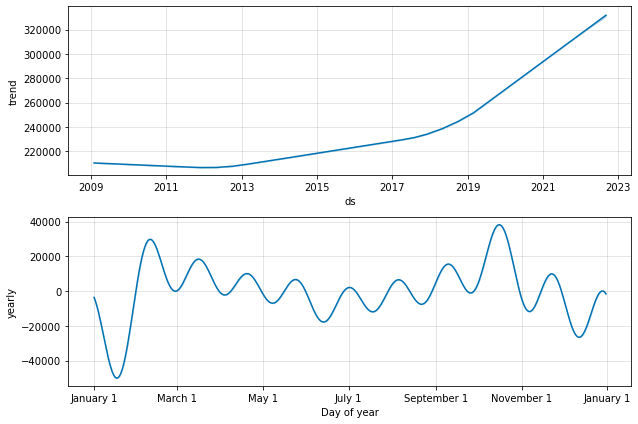

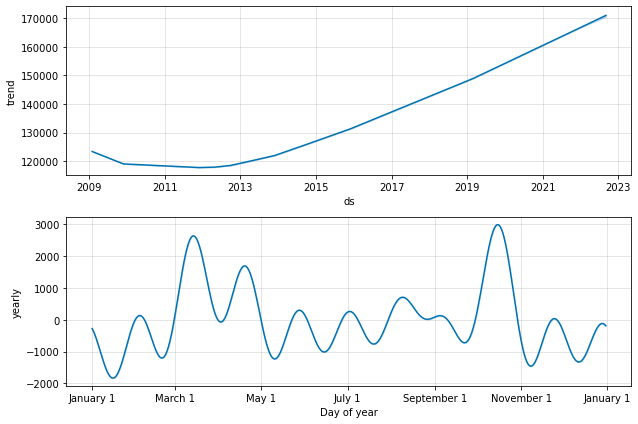

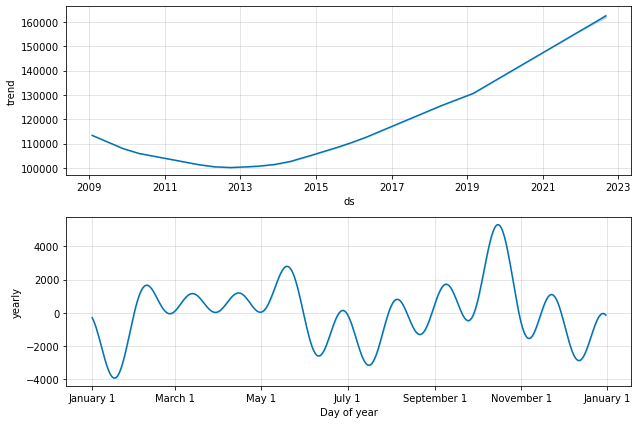

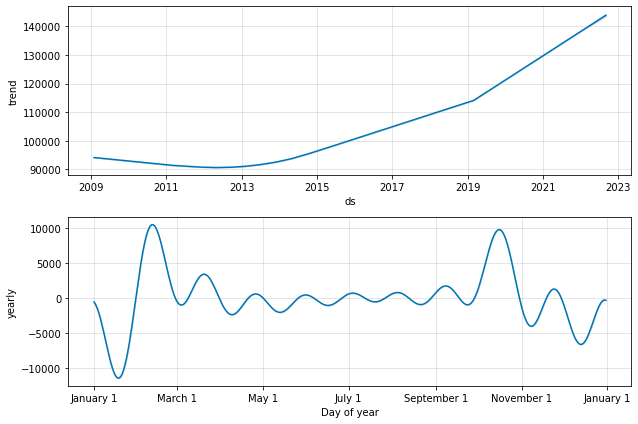

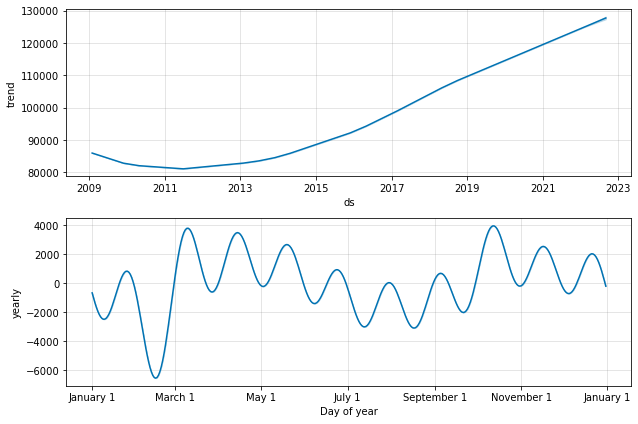

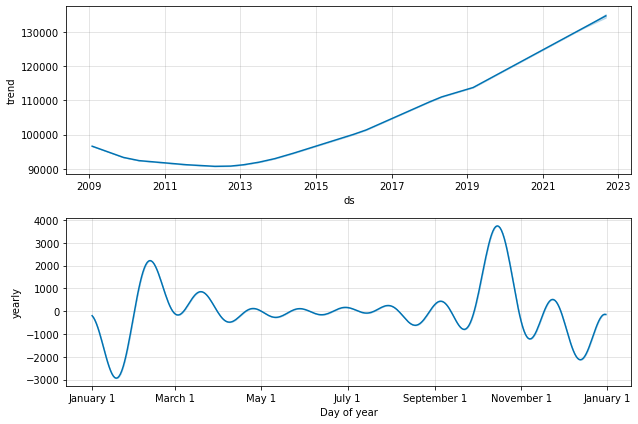

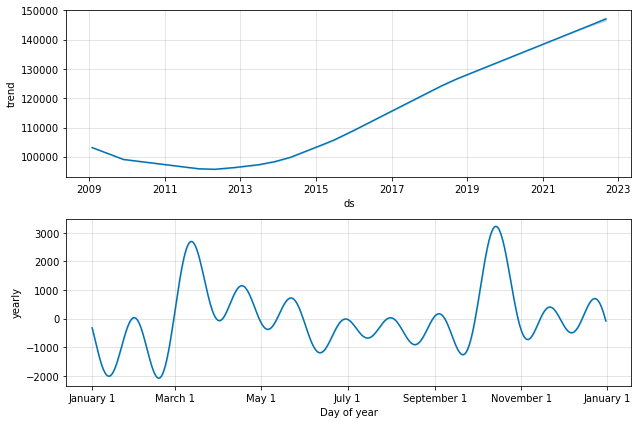

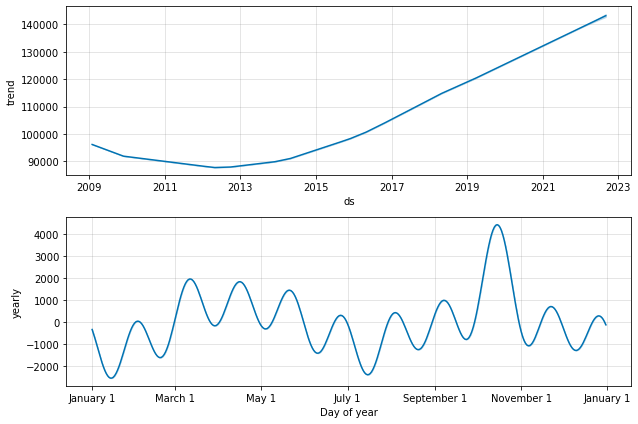

In [42]:
cities = [x for x in df['RegionName']]
# test = Facebook(cities)
test = [Facebook(i) for i in cities]
ROI_list = dict(zip(cities,test))
print(ROI_list)

In [40]:
data = dict(ROI_list)
ROI_list

{'New York': Figure({
     'data': [{'marker': {'color': 'black', 'size': 4},
               'mode': 'markers',
               'name': 'Actual',
               'type': 'scatter',
               'x': array([datetime.datetime(2009, 1, 31, 0, 0),
                           datetime.datetime(2009, 2, 28, 0, 0),
                           datetime.datetime(2009, 3, 31, 0, 0),
                           datetime.datetime(2009, 4, 30, 0, 0),
                           datetime.datetime(2009, 5, 31, 0, 0),
                           datetime.datetime(2009, 6, 30, 0, 0),
                           datetime.datetime(2009, 7, 31, 0, 0),
                           datetime.datetime(2009, 8, 31, 0, 0),
                           datetime.datetime(2009, 9, 30, 0, 0),
                           datetime.datetime(2009, 10, 31, 0, 0),
                           datetime.datetime(2009, 11, 30, 0, 0),
                           datetime.datetime(2009, 12, 31, 0, 0),
                           datetime.da

In [41]:
#Sort Cities by Highest ROI from the Facebook Prophet
pd.DataFrame.from_dict(data, orient='index').sort_values(by = 0, ascending=False).reset_index().head()

index     0       1       2
0   New York  data  layout  frames
1    Buffalo  data  layout  frames
2   Cortland  data  layout  frames
3  Amsterdam  data  layout  frames
4     Malone  data  layout  frames

# New York

In [26]:
Facebook_ROI('New York')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.147210820786012

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


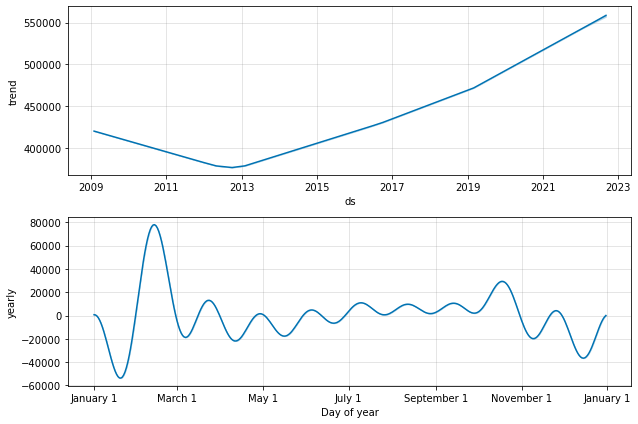

In [27]:
Facebook('New York')

# Buffalo

In [28]:
Facebook_ROI('Buffalo')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7.2040708930639035

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


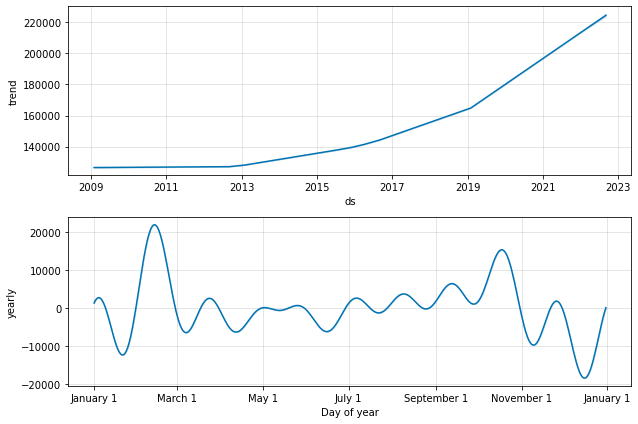

In [29]:
Facebook('Buffalo')

# Cortland

In [30]:
Facebook_ROI('Cortland')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.0869856989114006

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


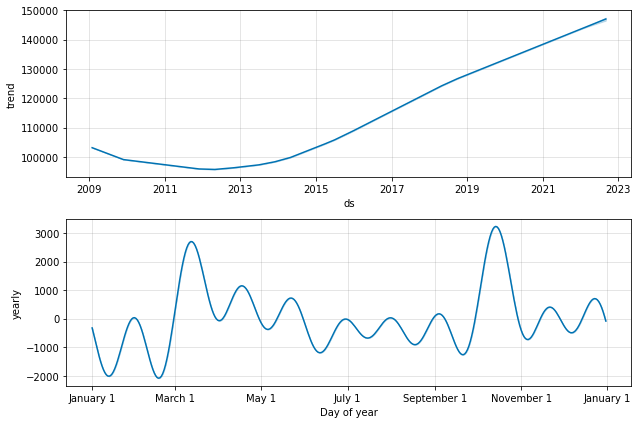

In [31]:
Facebook('Cortland')

# Amsterdam

In [32]:
Facebook_ROI('Amsterdam')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.010873653721422

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


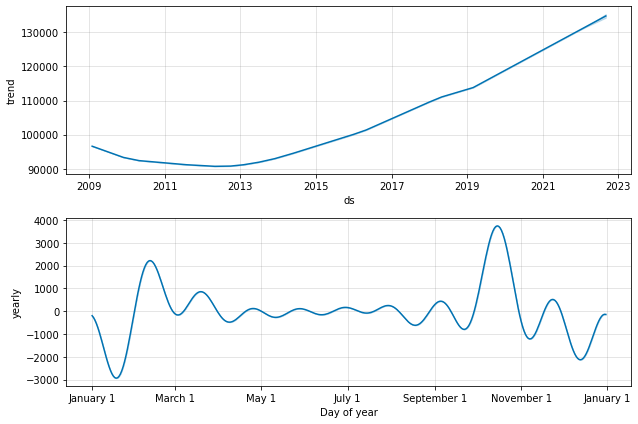

In [33]:
Facebook('Amsterdam')

# Malone

In [34]:
Facebook_ROI('Malone')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.358390860235174

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


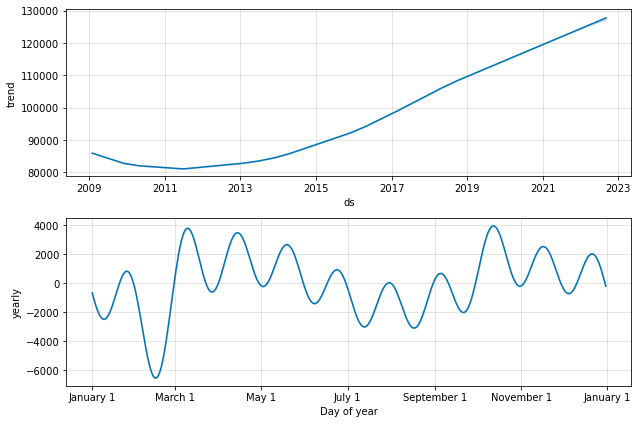

In [35]:
Facebook('Malone')

# Oneonta

In [36]:
Facebook_ROI('Oneonta')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.3427425152550336

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


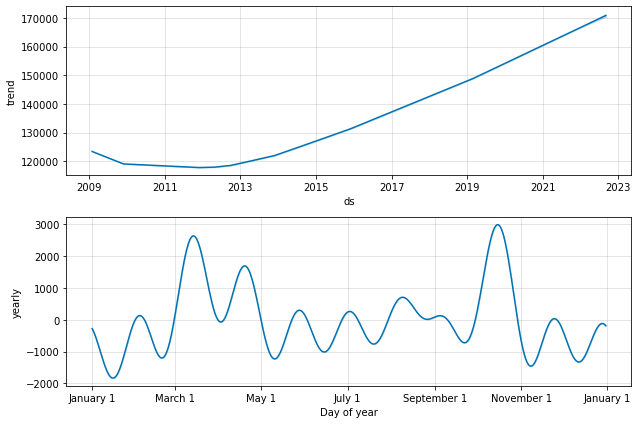

In [37]:
Facebook('Oneonta')

In [39]:

#[Latitude ,Longitude]
NY = folium.Map(location=[42.849710, -75.955242],zoom_start=6)

tooltip = "Click me!"
folium.Marker(
    [42.937745, -74.190356], popup="<i> Amsterdam </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [44.848660, -74.294899], popup="<i> Malone </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [42.880230, -78.878738], popup="<i> Buffalo </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [42.604729, -76.187370], popup="<i> Cortland </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [40.730610, -73.935242], popup="<i> New York </i>", tooltip=tooltip
).add_to(NY)

NY